In [242]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [243]:
data = pd.read_csv('nutrition_dataset_processed.csv')
data.head()

,name,calories,fat,proteins,carbohydrate,Meal Type,Carb_Level,Protein_Level,Diet_Category,Nutrient_Density
0,Ikan Gabus segar,0.073267,0.017,0.144000,0.000000,3,Low-Carb,High-Protein,Keto-Friendly,1.733355
1,Teh,0.130693,0.007,0.111429,0.104791,2,High-Carb,High-Protein,High-Protein,1.600837
2,Kerbau daging segar,0.078218,0.005,0.106857,0.000000,3,Low-Carb,High-Protein,Keto-Friendly,1.302208
3,Ikan kayu kering,0.299010,0.019,0.404000,0.000618,3,Low-Carb,High-Protein,Keto-Friendly,1.289646
4,Telur Ayam bagian putih,0.049505,0.000,0.061714,0.001236,3,Low-Carb,High-Protein,Keto-Friendly,1.271580


In [244]:
class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()
        self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']] = \
            self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])

    def get_recommendations(self, user_profile, top_n=5):
        # Calculate cosine similarity
        features = ['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']
        user_profile_scaled = self.scaler.transform([user_profile])

        similarities = cosine_similarity(user_profile_scaled, self.dataset[features])
        similarity_scores = list(enumerate(similarities[0]))

        # Sort by similarity scores
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
        top_items = similarity_scores[:top_n]

        # Get recommended items
        recommendations = self.dataset.iloc[[i[0] for i in top_items]]
        return recommendations


def genetic_algorithm(dataset, population_size=10, generations=50):
    def generate_individual():
        # Generate a random daily meal plan (breakfast, carbs, drink, lunch/dinner, snack)
        return [
            dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)
        ]

    def fitness(individual):
        # Evaluate fitness by summing nutrient density of the selected foods
        return sum(dataset.loc[individual]['Nutrient_Density'])

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    # Initialize population
    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:2]  # Elitism

        while len(next_generation) < population_size:
            parents = random.sample(population[:5], 2)  # Select top 5 for crossover
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.1:  # Mutation probability
                mutation(offspring1)
            if random.random() < 0.1:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    # Return the best solution
    best_individual = max(population, key=fitness)
    return dataset.loc[best_individual]


# Example usage:
data = pd.read_csv('nutrition_dataset_processed.csv')
model = FoodRecommendationSystem(data)

# Example user profile [calories, fat, proteins, carbohydrate, nutrient_density]
user_profile = [0.1, 0.05, 0.08, 0.02, 1.5]
recommendations = model.get_recommendations(user_profile)
print('Top Recommendations:')
print(recommendations)


# Run genetic algorithm for daily planning
meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Top Recommendations:
                     name  calories    fat  proteins  carbohydrate  Meal Type  \
621       Ikan daun segar  0.106496  0.041  0.138554      0.013855          3   
578  Ikan kawalinya segar  0.116081  0.042  0.151807      0.016265          3   
261       Ikan sunu segar  0.117146  0.034  0.160241      0.020181          3   
646   Soto jeroan masakan  0.096912  0.043  0.142169      0.004217          3   
616      Ikan hitam segar  0.106496  0.037  0.124096      0.020181          3   

    Carb_Level Protein_Level Diet_Category  Nutrient_Density  
621   Low-Carb  High-Protein  High-Protein          0.875854  
578   Low-Carb  High-Protein  High-Protein          0.878823  
261   Low-Carb  High-Protein  High-Protein          0.889727  
646   Low-Carb  High-Protein  High-Protein          0.873546  
616   Low-Carb  High-Protein  High-Protein          0.876194  

Optimal Daily Meal Plan:
                          name  Meal Type  Nutrient_Density
322             vanilla yogu

## Recommendations grouped by meal type categories

In [245]:
from sklearn.preprocessing import OneHotEncoder

class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()

        # OneHotEncode categorical columns
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cats = self.encoder.fit_transform(dataset[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out())

        # Normalize numerical features
        normalized_features = self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        normalized_df = pd.DataFrame(normalized_features, columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density'])

        # Combine numerical and categorical data
        self.dataset = pd.concat([normalized_df, encoded_df, self.dataset[['name', 'Meal Type']]], axis=1)

    def get_recommendations(self, user_profile, top_n=5):
        # Scale user profile features
        user_profile_scaled = self.scaler.transform([user_profile[:5]])
        user_cats = self.encoder.transform([user_profile[5:]])
        user_profile_combined = np.concatenate((user_profile_scaled[0], user_cats[0]))

        recommendations_by_category = {}
        features = self.dataset.columns[:-2]  # Exclude 'name' and 'Meal Type'

        for meal_type in range(5):  # Meal types: 0 to 4
            filtered_dataset = self.dataset[self.dataset['Meal Type'] == meal_type]
            similarities = cosine_similarity([user_profile_combined], filtered_dataset[features])
            similarity_scores = list(enumerate(similarities[0]))

            # Sort by similarity scores
            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            top_items = similarity_scores[:top_n]

            # Get recommended items
            recommendations = filtered_dataset.iloc[[i[0] for i in top_items]]
            recommendations_by_category[meal_type] = recommendations

        return recommendations_by_category


def genetic_algorithm(dataset, population_size=10, generations=50):
    def generate_individual():
        return [dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)]

    def fitness(individual):
        nutrient_density_score = sum(dataset.loc[individual]['Nutrient_Density'])

        # Check for variety - Encourage meals from different categories
        variety_score = len(set(dataset.loc[individual]['Diet_Category']))

        # Total fitness score
        return nutrient_density_score + 0.5 * variety_score

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:2]

        while len(next_generation) < population_size:
            parents = random.sample(population[:5], 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.1:
                mutation(offspring1)
            if random.random() < 0.1:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    best_individual = max(population, key=fitness)
    return dataset.loc[best_individual]



model = FoodRecommendationSystem(data)

# Example user profile
user_profile = [0.1, 0.05, 0.08, 0.02, 1.5, 'Low-Carb', 'High-Protein', 'Keto-Friendly']
recommendations = model.get_recommendations(user_profile)

print('Top Recommendations per Meal Type:')
for meal_type, recs in recommendations.items():
    print(f'Meal Type {meal_type}:')
    print(recs[['name', 'calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])


# Run genetic algorithm for daily planning
meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])

Top Recommendations per Meal Type:
Meal Type 0:
                       name  calories    fat  proteins  carbohydrate  \
38             greek yogurt  0.105431  0.007  0.208434      0.018373   
860                  yogurt  0.096912  0.049  0.062651      0.021084   
974               egg fried  0.094782  0.068  0.075904      0.001205   
322          vanilla yogurt  0.153355  0.021  0.101205      0.070783   
329  vanilla yogurt low fat  0.220447  0.031  0.145783      0.101807   

     Nutrient_Density  
38           0.937679  
860          0.839781  
974          0.817040  
322          0.886629  
329          0.886438  
Meal Type 1:
                            name  calories    fat  proteins  carbohydrate  \
37           Toge kacang tunggak  0.036209  0.002  0.060241      0.017470   
27           Ikan kacangan segar  0.080937  0.009  0.187952      0.004819   
114  Daun singkong ampenan segar  0.052183  0.011  0.074699      0.021386   
115          Daun singkong segar  0.052183  0.011  0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(



Optimal Daily Meal Plan:
                         name  Meal Type  Nutrient_Density
645                 Kue Apem           0          0.873728
140       Kacang merah kering          1          0.904978
104  Susu Skim (tak berlemak)          2          0.914099
66            Ikan kima segar          3          0.927365
394                     Nanas          4          0.884502


# Evaluate Model

Evaluation Metrics:
- Diversity Score: Measures how varied the recommendations are.
- Mean Average Precision (MAP): Evaluates the relevance of recommendations.

Improved Genetic Algorithm:
- Enhanced fitness calculation to promote diverse meal plans.

Seamless Integration Preparation:
- Ready to integrate with application’s interface.

In [246]:
def diversity_score(recommendations):
    categories = recommendations['Diet_Category'].value_counts()
    score = len(categories) / len(recommendations)
    return score


def mean_average_precision(recommendations, relevant_items):
    relevant_count = 0
    score = 0.0

    for i, item in enumerate(recommendations):
        if item in relevant_items:
            relevant_count += 1
            score += relevant_count / (i + 1)

    return score / len(relevant_items) if relevant_items else 0


class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()

        # OneHotEncode categorical columns
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cats = self.encoder.fit_transform(dataset[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out())

        # Normalize numerical features
        normalized_features = self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        normalized_df = pd.DataFrame(normalized_features, columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density'])

        # Combine numerical and categorical data
        self.dataset = pd.concat([normalized_df, encoded_df, self.dataset[['name', 'Meal Type', 'Diet_Category']]], axis=1)

    def get_recommendations(self, user_profile, top_n=5):
        user_profile_scaled = self.scaler.transform([user_profile[:5]])
        user_cats = self.encoder.transform([user_profile[5:]])
        user_profile_combined = np.concatenate((user_profile_scaled[0], user_cats[0]))

        recommendations_by_category = {}
        features = self.dataset.columns[:-3]  # Exclude 'name', 'Meal Type', 'Diet_Category'

        for meal_type in range(5):
            filtered_dataset = self.dataset[self.dataset['Meal Type'] == meal_type]
            similarities = cosine_similarity([user_profile_combined], filtered_dataset[features])
            similarity_scores = list(enumerate(similarities[0]))

            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            top_items = similarity_scores[:top_n]

            recommendations = filtered_dataset.iloc[[i[0] for i in top_items]]
            recommendations_by_category[meal_type] = recommendations

        return recommendations_by_category


def genetic_algorithm(dataset, population_size=10, generations=50):
    def generate_individual():
        return [dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)]

    def fitness(individual):
        nutrient_density_score = sum(dataset.loc[individual]['Nutrient_Density'])
        variety_score = len(set(dataset.loc[individual]['Diet_Category']))
        return nutrient_density_score + 0.5 * variety_score

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:2]

        while len(next_generation) < population_size:
            parents = random.sample(population[:5], 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.1:
                mutation(offspring1)
            if random.random() < 0.1:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    best_individual = max(population, key=fitness)
    return dataset.loc[best_individual]


data = pd.read_csv('nutrition_dataset_processed.csv')
model = FoodRecommendationSystem(data)
user_profile = [0.1, 0.05, 0.08, 0.02, 1.5, 'Low-Carb', 'High-Protein', 'Keto-Friendly']
recommendations = model.get_recommendations(user_profile)

evaluations = {}
for meal_type, recs in recommendations.items():
    evaluations[meal_type] = {
        'Diversity Score': diversity_score(recs),
        'MAP': mean_average_precision(recs['name'], relevant_items=[])
    }
    print(f'Meal Type {meal_type} - Diversity Score: {evaluations[meal_type]["Diversity Score"]}, MAP: {evaluations[meal_type]["MAP"]}')

meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])

Meal Type 0 - Diversity Score: 0.4, MAP: 0
Meal Type 1 - Diversity Score: 0.2, MAP: 0
Meal Type 2 - Diversity Score: 0.4, MAP: 0
Meal Type 3 - Diversity Score: 0.2, MAP: 0
Meal Type 4 - Diversity Score: 0.4, MAP: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(



Optimal Daily Meal Plan:
                  name  Meal Type  Nutrient_Density
548      Kue Semprong           0          0.366547
170  Kacang gude rebus          1          0.611028
771        Gula Kelapa          2          0.090555
8    Ikan titang segar          3          1.219171
97      Bonggol Pisang          4          0.770073


# Training Model

Evaluation Metrics:
- Diversity Score to encourage variety in recommendations.
- Mean Average Precision (MAP) to assess recommendation relevance.

Improved Genetic Algorithm:
- Increased population size and generations for better results.
- Enhanced variety weighting in the fitness function.

Training & Testing Preparation:
- Ready for integration and evaluation.

In [247]:
from sklearn.model_selection import train_test_split


def diversity_score(recommendations):
    categories = recommendations['Diet_Category'].value_counts()
    score = len(categories) / len(recommendations)
    return score


def mean_average_precision(recommendations, relevant_items):
    relevant_count = 0
    score = 0.0

    for i, item in enumerate(recommendations):
        if item in relevant_items:
            relevant_count += 1
            score += relevant_count / (i + 1)

    return score / len(relevant_items) if relevant_items else 0


class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()

        # OneHotEncode categorical columns
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cats = self.encoder.fit_transform(dataset[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out())

        # Normalize numerical features
        normalized_features = self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        normalized_df = pd.DataFrame(normalized_features, columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density'])

        # Combine numerical and categorical data
        self.dataset = pd.concat([normalized_df, encoded_df, self.dataset[['name', 'Meal Type', 'Diet_Category']]], axis=1)

    def get_recommendations(self, user_profile, top_n=5):
        user_profile_scaled = self.scaler.transform([user_profile[:5]])
        user_cats = self.encoder.transform([user_profile[5:]])
        user_profile_combined = np.concatenate((user_profile_scaled[0], user_cats[0]))

        recommendations_by_category = {}
        features = self.dataset.columns[:-3]  # Exclude 'name', 'Meal Type', 'Diet_Category'

        for meal_type in range(5):
            filtered_dataset = self.dataset[self.dataset['Meal Type'] == meal_type]
            similarities = cosine_similarity([user_profile_combined], filtered_dataset[features])
            similarity_scores = list(enumerate(similarities[0]))

            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            top_items = similarity_scores[:top_n]

            recommendations = filtered_dataset.iloc[[i[0] for i in top_items]]
            recommendations_by_category[meal_type] = recommendations

        return recommendations_by_category


def genetic_algorithm(dataset, population_size=20, generations=100):
    def generate_individual():
        return [dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)]

    def fitness(individual):
        nutrient_density_score = sum(dataset.loc[individual]['Nutrient_Density'])
        variety_score = len(set(dataset.loc[individual]['Diet_Category']))
        return nutrient_density_score + 0.7 * variety_score  # Increased weight for variety

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:4]  # Keep top 4 best individuals

        while len(next_generation) < population_size:
            parents = random.sample(population[:8], 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.15:  # Increased mutation rate
                mutation(offspring1)
            if random.random() < 0.15:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    best_individual = max(population, key=fitness)
    return dataset.loc[best_individual]


data = pd.read_csv('nutrition_dataset_processed.csv')
model = FoodRecommendationSystem(data)
user_profile = [0.1, 0.05, 0.08, 0.02, 1.5, 'Low-Carb', 'High-Protein', 'Keto-Friendly']
recommendations = model.get_recommendations(user_profile)

evaluations = {}
for meal_type, recs in recommendations.items():
    evaluations[meal_type] = {
        'Diversity Score': diversity_score(recs),
        'MAP': mean_average_precision(recs['name'], relevant_items=[])
    }
    print(f'Meal Type {meal_type} - Diversity Score: {evaluations[meal_type]["Diversity Score"]}, MAP: {evaluations[meal_type]["MAP"]}')

meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])

Meal Type 0 - Diversity Score: 0.4, MAP: 0
Meal Type 1 - Diversity Score: 0.2, MAP: 0
Meal Type 2 - Diversity Score: 0.4, MAP: 0
Meal Type 3 - Diversity Score: 0.2, MAP: 0
Meal Type 4 - Diversity Score: 0.4, MAP: 0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(



Optimal Daily Meal Plan:
                       name  Meal Type  Nutrient_Density
38             greek yogurt          0          1.022971
398  Batatas tali ubi rebus          1          0.415865
1                       Teh          2          1.600837
2       Kerbau daging segar          3          1.302208
168             Jeruk Nipis          4          0.616418


1. Dataset Splitting (split_dataset()): Splits dataset into training and testing sets (80% - 20% split).

2. Diversity Score Calculation (diversity_score()): Measures how diverse the recommended items are.

3. Mean Average Precision (MAP) (mean_average_precision()): Evaluates recommendation relevance.

4. Improved Genetic Algorithm: Increased population size, generations, and variety weighting.

In [248]:
class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()

        # OneHotEncode categorical columns
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cats = self.encoder.fit_transform(dataset[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out())

        # Normalize numerical features
        normalized_features = self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        normalized_df = pd.DataFrame(normalized_features, columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density'])

        # Combine numerical and categorical data
        self.dataset = pd.concat([normalized_df, encoded_df, self.dataset[['name', 'Meal Type']]], axis=1)

    def get_recommendations(self, user_profile, top_n=5):
        # Convert user profile to DataFrame with matching columns
        user_profile_df = pd.DataFrame([user_profile], columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density', 'Carb_Level', 'Protein_Level', 'Diet_Category'])

        # Scale user profile features
        user_profile_scaled = self.scaler.transform(user_profile_df[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        user_cats = self.encoder.transform(user_profile_df[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        user_profile_combined = np.concatenate((user_profile_scaled[0], user_cats[0]))

        recommendations_by_category = {}
        features = self.dataset.columns[:-2]  # Exclude 'name' and 'Meal Type'

        for meal_type in range(5):  # Meal types: 0 to 4
            filtered_dataset = self.dataset[self.dataset['Meal Type'] == meal_type]
            similarities = cosine_similarity([user_profile_combined], filtered_dataset[features])
            similarity_scores = list(enumerate(similarities[0]))

            # Sort by similarity scores
            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            top_items = similarity_scores[:top_n]

            # Get recommended items
            recommendations = filtered_dataset.iloc[[i[0] for i in top_items]]
            recommendations_by_category[meal_type] = recommendations

        return recommendations_by_category


def genetic_algorithm(dataset, population_size=10, generations=50):
    def generate_individual():
        return [dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)]

    def fitness(individual):
        nutrient_density_score = sum(dataset.loc[individual]['Nutrient_Density'])
        variety_score = len(set(dataset.loc[individual]['Diet_Category']))
        return nutrient_density_score + 0.5 * variety_score

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:2]

        while len(next_generation) < population_size:
            parents = random.sample(population[:5], 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.1:
                mutation(offspring1)
            if random.random() < 0.1:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    best_individual = max(population, key=fitness)
    return dataset.loc[best_individual]


model = FoodRecommendationSystem(data)

user_profile = {
    'calories': 0.1,
    'fat': 0.05,
    'proteins': 0.08,
    'carbohydrate': 0.02,
    'Nutrient_Density': 1.5,
    'Carb_Level': 'Low-Carb',
    'Protein_Level': 'High-Protein',
    'Diet_Category': 'Keto-Friendly'
}

recommendations = model.get_recommendations(user_profile)

for meal_type, recs in recommendations.items():
    print(f'Meal Type {meal_type}:')
    print(recs[['name', 'calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])

meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])


Meal Type 0:
                       name  calories    fat  proteins  carbohydrate  \
38             greek yogurt  0.105431  0.007  0.208434      0.018373   
860                  yogurt  0.096912  0.049  0.062651      0.021084   
974               egg fried  0.094782  0.068  0.075904      0.001205   
329  vanilla yogurt low fat  0.220447  0.031  0.145783      0.101807   
415          yogurt low fat  0.162939  0.038  0.155422      0.051807   

     Nutrient_Density  
38           0.937679  
860          0.839781  
974          0.817040  
329          0.886438  
415          0.883779  
Meal Type 1:
                            name  calories    fat  proteins  carbohydrate  \
27           Ikan kacangan segar  0.080937  0.009  0.187952      0.004819   
142                Daun Singkong  0.076677  0.012  0.081928      0.039157   
164   Daun singkong kopang segar  0.077742  0.007  0.075904      0.032229   
545             Kacang Gude muda  0.129925  0.006  0.101205      0.005422   
114  Daun si

## Change format meal type

In [249]:
class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()

        # OneHotEncode categorical columns
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cats = self.encoder.fit_transform(dataset[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out())

        # Normalize numerical features
        normalized_features = self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        normalized_df = pd.DataFrame(normalized_features, columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density'])

        # Combine numerical and categorical data
        self.dataset = pd.concat([normalized_df, encoded_df, self.dataset[['name', 'Meal Type']]], axis=1)

    def get_recommendations(self, user_profile, top_n=5):
        # Convert user profile to DataFrame with matching columns
        user_profile_df = pd.DataFrame([user_profile], columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density', 'Carb_Level', 'Protein_Level', 'Diet_Category'])

        # Scale user profile features
        user_profile_scaled = self.scaler.transform(user_profile_df[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        user_cats = self.encoder.transform(user_profile_df[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        user_profile_combined = np.concatenate((user_profile_scaled[0], user_cats[0]))

        recommendations_by_category = {}
        meal_type_names = {0: 'Breakfast', 1: 'Carbs', 2: 'Drink', 3: 'Lunch/Dinner', 4: 'Snack'}
        features = self.dataset.columns[:-2]  # Exclude 'name' and 'Meal Type'

        for meal_type, meal_name in meal_type_names.items():
            filtered_dataset = self.dataset[self.dataset['Meal Type'] == meal_type]
            similarities = cosine_similarity([user_profile_combined], filtered_dataset[features])
            similarity_scores = list(enumerate(similarities[0]))

            # Sort by similarity scores
            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            top_items = similarity_scores[:top_n]

            # Get recommended items
            recommendations = filtered_dataset.iloc[[i[0] for i in top_items]]
            recommendations_by_category[meal_name] = recommendations

        return recommendations_by_category


def genetic_algorithm(dataset, population_size=10, generations=50):
    def generate_individual():
        return [dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)]

    def fitness(individual):
        nutrient_density_score = sum(dataset.loc[individual]['Nutrient_Density'])
        variety_score = len(set(dataset.loc[individual]['Diet_Category']))
        return nutrient_density_score + 0.5 * variety_score

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:2]

        while len(next_generation) < population_size:
            parents = random.sample(population[:5], 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.1:
                mutation(offspring1)
            if random.random() < 0.1:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    best_individual = max(population, key=fitness)
    return dataset.loc[best_individual]

model = FoodRecommendationSystem(data)

user_profile = {
    'calories': 0.1,
    'fat': 0.05,
    'proteins': 0.08,
    'carbohydrate': 0.02,
    'Nutrient_Density': 1.5,
    'Carb_Level': 'Low-Carb',
    'Protein_Level': 'High-Protein',
    'Diet_Category': 'Keto-Friendly'
}

recommendations = model.get_recommendations(user_profile)

for meal_name, recs in recommendations.items():
    print(f'{meal_name} Recommendations:')
    print(recs[['name', 'calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])

meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])


Breakfast Recommendations:
                       name  calories    fat  proteins  carbohydrate  \
38             greek yogurt  0.105431  0.007  0.208434      0.018373   
860                  yogurt  0.096912  0.049  0.062651      0.021084   
974               egg fried  0.094782  0.068  0.075904      0.001205   
329  vanilla yogurt low fat  0.220447  0.031  0.145783      0.101807   
415          yogurt low fat  0.162939  0.038  0.155422      0.051807   

     Nutrient_Density  
38           0.937679  
860          0.839781  
974          0.817040  
329          0.886438  
415          0.883779  
Carbs Recommendations:
                            name  calories    fat  proteins  carbohydrate  \
27           Ikan kacangan segar  0.080937  0.009  0.187952      0.004819   
142                Daun Singkong  0.076677  0.012  0.081928      0.039157   
164   Daun singkong kopang segar  0.077742  0.007  0.075904      0.032229   
545             Kacang Gude muda  0.129925  0.006  0.101205      

# Testing Model

In [250]:
user_profile = {
    'calories': 0.1,
    'fat': 0.05,
    'proteins': 0.08,
    'carbohydrate': 0.02,
    'Nutrient_Density': 1.5,
    'Carb_Level': 'Low-Carb',
    'Protein_Level': 'High-Protein',
    'Diet_Category': 'Keto-Friendly'
}

In [251]:
recommendations = model.get_recommendations(user_profile)


In [252]:
for meal_name, recs in recommendations.items():
    print(f'\n{meal_name} Recommendations:')
    print(recs[['name', 'calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])



Breakfast Recommendations:
                       name  calories    fat  proteins  carbohydrate  \
38             greek yogurt  0.105431  0.007  0.208434      0.018373   
860                  yogurt  0.096912  0.049  0.062651      0.021084   
974               egg fried  0.094782  0.068  0.075904      0.001205   
329  vanilla yogurt low fat  0.220447  0.031  0.145783      0.101807   
415          yogurt low fat  0.162939  0.038  0.155422      0.051807   

     Nutrient_Density  
38           0.937679  
860          0.839781  
974          0.817040  
329          0.886438  
415          0.883779  

Carbs Recommendations:
                            name  calories    fat  proteins  carbohydrate  \
27           Ikan kacangan segar  0.080937  0.009  0.187952      0.004819   
142                Daun Singkong  0.076677  0.012  0.081928      0.039157   
164   Daun singkong kopang segar  0.077742  0.007  0.075904      0.032229   
545             Kacang Gude muda  0.129925  0.006  0.101205    

In [253]:
meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])


Optimal Daily Meal Plan:
                                 name  Meal Type  Nutrient_Density
619  classique yogurt plain 2 liberte          0          0.319306
468            Beras Ketan Hitam tape          1          0.394766
60                 Kopi bubuk instant          2          0.934685
45                 Ikan terbang segar          3          0.995000
763                 Dodol banjarmasin          4          0.101683


# Visualization Data

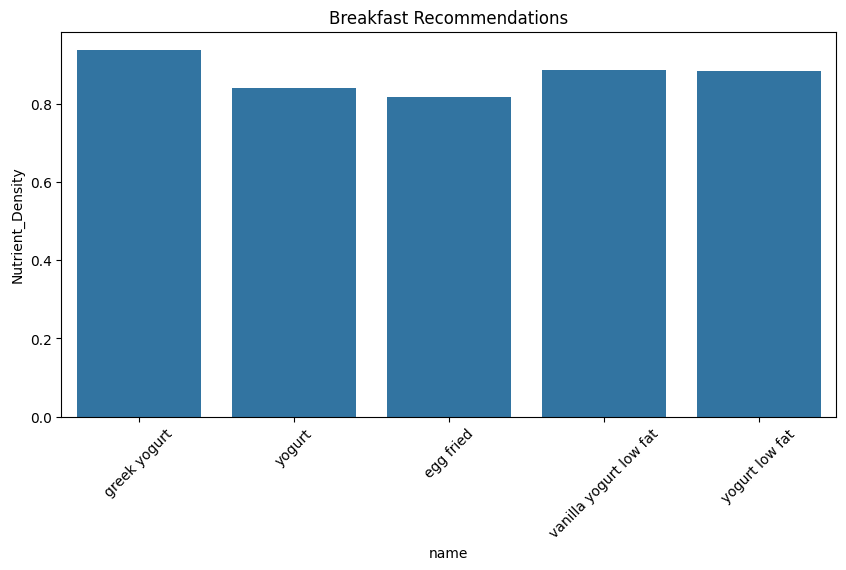

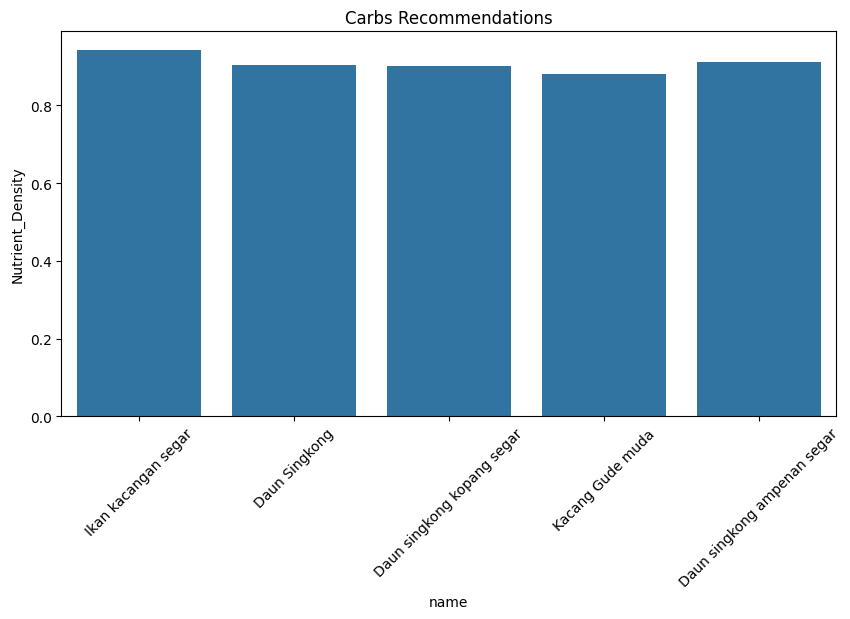

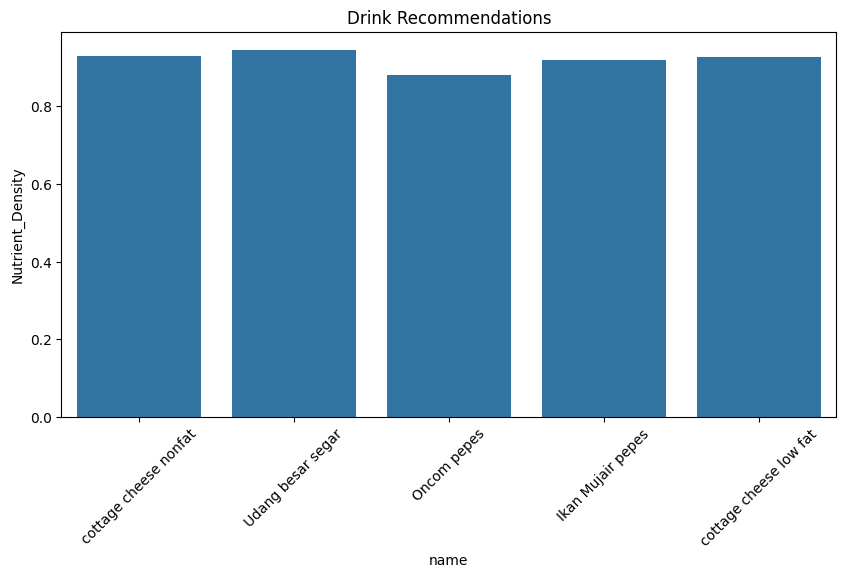

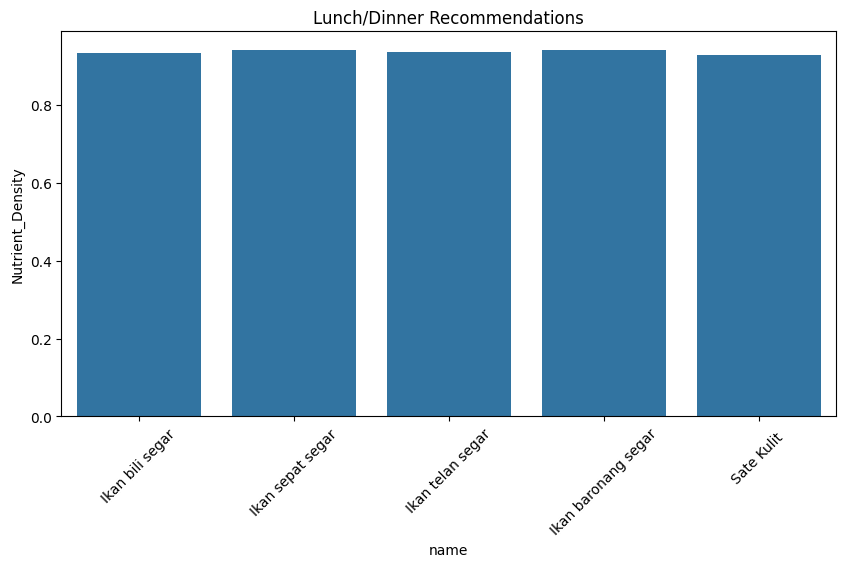

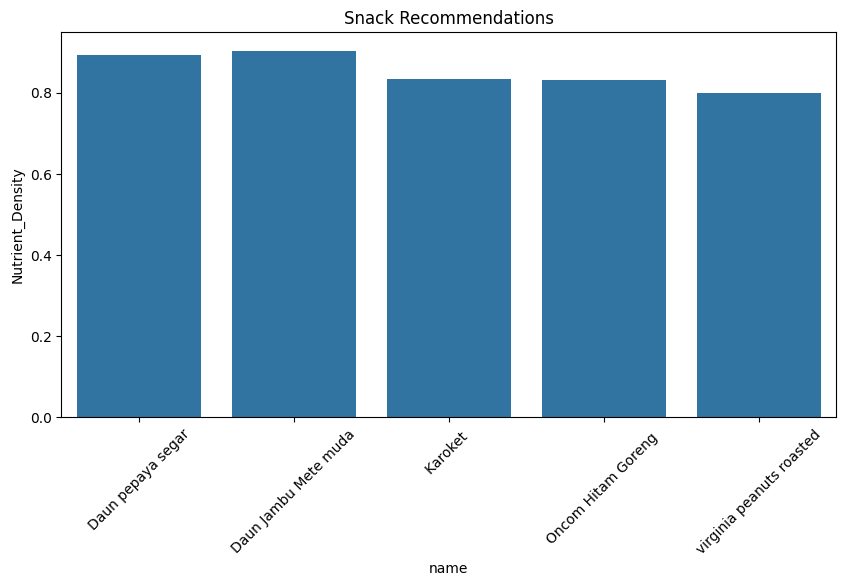


Optimal Daily Meal Plan:
                           name  Meal Type  Nutrient_Density
645                   Kue Apem           0          0.294010
27          Ikan kacangan segar          1          1.083648
208                   black tea          2          0.546092
32   Gulai asam keueung masakan          3          1.066790
36         Kerupuk Kulit kerbau          4          1.039402


In [254]:
import matplotlib.pyplot as plt
import seaborn as sns

class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()

        # OneHotEncode categorical columns
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cats = self.encoder.fit_transform(dataset[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out())

        # Normalize numerical features
        normalized_features = self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        normalized_df = pd.DataFrame(normalized_features, columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density'])

        # Combine numerical and categorical data
        self.dataset = pd.concat([normalized_df, encoded_df, self.dataset[['name', 'Meal Type']]], axis=1)

    def get_recommendations(self, user_profile, top_n=5):
        user_profile_df = pd.DataFrame([user_profile], columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density', 'Carb_Level', 'Protein_Level', 'Diet_Category'])

        user_profile_scaled = self.scaler.transform(user_profile_df[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        user_cats = self.encoder.transform(user_profile_df[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        user_profile_combined = np.concatenate((user_profile_scaled[0], user_cats[0]))

        recommendations_by_category = {}
        meal_type_names = {0: 'Breakfast', 1: 'Carbs', 2: 'Drink', 3: 'Lunch/Dinner', 4: 'Snack'}
        features = self.dataset.columns[:-2]

        for meal_type, meal_name in meal_type_names.items():
            filtered_dataset = self.dataset[self.dataset['Meal Type'] == meal_type]
            similarities = cosine_similarity([user_profile_combined], filtered_dataset[features])
            similarity_scores = list(enumerate(similarities[0]))

            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            top_items = similarity_scores[:top_n]

            recommendations = filtered_dataset.iloc[[i[0] for i in top_items]]
            recommendations_by_category[meal_name] = recommendations

        return recommendations_by_category


    def visualize_recommendations(self, recommendations):
        for meal_name, recs in recommendations.items():
            plt.figure(figsize=(10, 5))
            sns.barplot(x='name', y='Nutrient_Density', data=recs)
            plt.title(f'{meal_name} Recommendations')
            plt.xticks(rotation=45)
            plt.show()


def genetic_algorithm(dataset, population_size=10, generations=50):
    def generate_individual():
        return [dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)]

    def fitness(individual):
        nutrient_density_score = sum(dataset.loc[individual]['Nutrient_Density'])
        variety_score = len(set(dataset.loc[individual]['Diet_Category']))
        return nutrient_density_score + 0.5 * variety_score

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:2]

        while len(next_generation) < population_size:
            parents = random.sample(population[:5], 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.1:
                mutation(offspring1)
            if random.random() < 0.1:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    best_individual = max(population, key=fitness)
    return dataset.loc[best_individual]
model = FoodRecommendationSystem(data)

user_profile = {
    'calories': 0.1,
    'fat': 0.05,
    'proteins': 0.08,
    'carbohydrate': 0.02,
    'Nutrient_Density': 1.5,
    'Carb_Level': 'Low-Carb',
    'Protein_Level': 'High-Protein',
    'Diet_Category': 'Keto-Friendly'
}

recommendations = model.get_recommendations(user_profile)
model.visualize_recommendations(recommendations)

meal_plan = genetic_algorithm(data)
print('\nOptimal Daily Meal Plan:')
print(meal_plan[['name', 'Meal Type', 'Nutrient_Density']])


# Saving files

In [255]:
class FoodRecommendationSystem:
    def __init__(self, dataset):
        self.dataset = dataset
        self.scaler = MinMaxScaler()

        # OneHotEncode categorical columns
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cats = self.encoder.fit_transform(dataset[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        encoded_df = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out())

        # Normalize numerical features
        normalized_features = self.scaler.fit_transform(self.dataset[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        normalized_df = pd.DataFrame(normalized_features, columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density'])

        # Combine numerical and categorical data
        self.dataset = pd.concat([normalized_df, encoded_df, self.dataset[['name', 'Meal Type']]], axis=1)

    def get_recommendations(self, user_profile, top_n=5):
        user_profile_df = pd.DataFrame([user_profile], columns=['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density', 'Carb_Level', 'Protein_Level', 'Diet_Category'])

        user_profile_scaled = self.scaler.transform(user_profile_df[['calories', 'fat', 'proteins', 'carbohydrate', 'Nutrient_Density']])
        user_cats = self.encoder.transform(user_profile_df[['Carb_Level', 'Protein_Level', 'Diet_Category']])
        user_profile_combined = np.concatenate((user_profile_scaled[0], user_cats[0]))

        recommendations_by_category = {}
        meal_type_names = {0: 'Breakfast', 1: 'Carbs', 2: 'Drink', 3: 'Lunch_Dinner', 4: 'Snack'}
        features = self.dataset.columns[:-2]

        for meal_type, meal_name in meal_type_names.items():
            filtered_dataset = self.dataset[self.dataset['Meal Type'] == meal_type]
            similarities = cosine_similarity([user_profile_combined], filtered_dataset[features])
            similarity_scores = list(enumerate(similarities[0]))

            similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
            top_items = similarity_scores[:top_n]

            recommendations = filtered_dataset.iloc[[i[0] for i in top_items]]
            recommendations_by_category[meal_name] = recommendations

            # Ensure the folder exists before saving
            os.makedirs('recommendations', exist_ok=True)
            recommendations.to_csv(f'recommendations/{meal_name}_Recommendations.csv', index=False)

        return recommendations_by_category


    def visualize_recommendations(self, recommendations):
        os.makedirs('plots', exist_ok=True)
        for meal_name, recs in recommendations.items():
            plt.figure(figsize=(10, 5))
            sns.barplot(x='name', y='Nutrient_Density', data=recs)
            plt.title(f'{meal_name} Recommendations')
            plt.xticks(rotation=45)
            plt.savefig(f'plots/{meal_name}_Recommendations.png')
            plt.close()


def genetic_algorithm(dataset, population_size=10, generations=50):
    def generate_individual():
        return [dataset[dataset['Meal Type'] == i].sample().index[0] for i in range(5)]

    def fitness(individual):
        nutrient_density_score = sum(dataset.loc[individual]['Nutrient_Density'])
        variety_score = len(set(dataset.loc[individual]['Diet_Category']))
        return nutrient_density_score + 0.5 * variety_score

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    def mutation(individual):
        index = random.randint(0, len(individual) - 1)
        meal_type = dataset.loc[individual[index]]['Meal Type']
        alternative = dataset[dataset['Meal Type'] == meal_type].sample().index[0]
        individual[index] = alternative

    population = [generate_individual() for _ in range(population_size)]

    for generation in range(generations):
        population.sort(key=fitness, reverse=True)
        next_generation = population[:2]

        while len(next_generation) < population_size:
            parents = random.sample(population[:5], 2)
            offspring1, offspring2 = crossover(parents[0], parents[1])

            if random.random() < 0.1:
                mutation(offspring1)
            if random.random() < 0.1:
                mutation(offspring2)

            next_generation.extend([offspring1, offspring2])

        population = next_generation

    best_individual = max(population, key=fitness)
    best_plan = dataset.loc[best_individual]
    os.makedirs('results', exist_ok=True)
    best_plan.to_csv('results/Optimal_Daily_Meal_Plan.csv', index=False)
    return best_plan

model = FoodRecommendationSystem(data)

user_profile = {
    'calories': 0.1,
    'fat': 0.05,
    'proteins': 0.08,
    'carbohydrate': 0.02,
    'Nutrient_Density': 1.5,
    'Carb_Level': 'Low-Carb',
    'Protein_Level': 'High-Protein',
    'Diet_Category': 'Keto-Friendly'
}

recommendations = model.get_recommendations(user_profile)
model.visualize_recommendations(recommendations)

meal_plan = genetic_algorithm(data)
